<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Григорьев Георгий Глебович (@thepowerfuldeez)

# <center>Уменьшение размерности с TSNE и сравнение скорости работы c UMAP</center>
## <center>В этом туториале будут рассмотрены библиотеки TSNE, Multicore TSNE и UMAP и будет произведено сравнение на датасете 20_newsgroups</center>

Всем привет! В нашем курсе частично поднималась тема Manifold Learning, но для большей ясности думаю стоит еще раз вспомнить про эту область машинного обучения и немного глубже затронуть ее аспекты.

> Manifold Learning – метод нелинейного уменьшения размерности, при котором обычно размерность настолько большая, что интерпретировать данные становится сложно.

К таким алгоритмам относятся t-SNE и uMAP, а к алгоритмам линейного уменьшения размерности – PCA, SVD.
Часто размерность уменьшают до 2 или 3, чтобы данные целиком можно было бы отобразить на двумерное или трехмерное пространство.

Тут надо подметить, что если размерность экстремально большая и исчисляется десятками тысяч, то нужно использовать более эффективные методы уменьшения размерности, например линейные PCA и SVD (но никто не запрещает использовать сначала PCA, а потом TSNE)

[tl;dr](#4.-Выводы)

# 1. Подготовка

Импортируем нужные библиотеки

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

Для установки Multicore TSNE может понадобиться cmake и gcc

На Windows склонировать репозиторий куда угодно и запустить pip install на эту директорию

Возможно придется заменить pip на pip3, если запускаете не из virtualenv

In [18]:
!git clone https://github.com/DmitryUlyanov/Multicore-TSNE.git && pip install Multicore-TSNE/ && rm -rf Multicore-TSNE/

Cloning into 'Multicore-TSNE'...
remote: Counting objects: 479, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 479 (delta 0), reused 0 (delta 0), pack-reused 475
Receiving objects: 100% (479/479), 418.31 KiB | 85.00 KiB/s, done.
Resolving deltas: 100% (278/278), done.
Processing ./Multicore-TSNE
  Running setup.py bdist_wheel for MulticoreTSNE ... done
  Stored in directory: /Users/thepowerfuldeez/Library/Caches/pip/wheels/1a/bb/16/2146afcae4f12a1bba4be16447c14f307fb079d40e2bc94323
Successfully built MulticoreTSNE
You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from MulticoreTSNE import MulticoreTSNE

Установим uMAP, для установки может потребоваться установить numba вручную, но все должно встать автоматически

In [19]:
!pip install umap-learn
# так же, возможно придется заменить на pip3

    100% |████████████████████████████████| 1.5MB 640kB/s ta 0:00:01
    100% |████████████████████████████████| 11.7MB 95kB/s eta 0:00:01
You are using pip version 9.0.3, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from umap import UMAP

Загрузим первый датасет 20_newsgroups

In [13]:
# from sklearn.datasets import fetch_20newsgroups
# newsgroups = fetch_20newsgroups('all')
# Можно было бы их скачать таким образом, но из-за блокировки серверов AWS РКН ссылка не работает

Поэтому я нашел оригинальную ссылку, на Windows придется [скачать](http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz) и распаковать вручную и закинуть папку 20news-18828 в /data

In [33]:
!wget -O ../../data/20news-18828.tar.gz http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz && tar -xzf ../../data/20news-18828.tar.gz -C ../../data && rm ../../data/20news-18828.tar.gz

--2018-04-21 14:04:13--  http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz
Resolving qwone.com... 173.48.216.16
Connecting to qwone.com|173.48.216.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14666916 (14M) [application/x-gzip]
Saving to: '../../data/20news-18828.tar.gz'

../../data/20news-1 100%[===================>]  13.99M   530KB/s    in 27s     

2018-04-21 14:04:40 (535 KB/s) - '../../data/20news-18828.tar.gz' saved [14666916/14666916]



Текст нужно препроцессить, используем TfIdfVectorizer со следующими параметрами:

 - ``input='filename'``: использует напрямую пути к файлам, векторизатор умеет их читать сам.    


 - ``decode_error='ignore'``: пропускать проблемные участки текстов (не все из них закодированы удачно, т.к. мы скачали датасет напрямую, а проводить тщательный анализ текстов не входит в цель данного урока) Мы увидим, что так мы не пропустим ни один файл.


 - ``max_features=100000``: Для наглядности ограничим размерность X 100000, вообще полная размерность была бы 170000

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
# названия классов = названия директорий, которые содержат файлы с текстами
labels = [a for a in os.listdir("../../data/20news-18828/") if a != ".DS_Store"]

X = []
y = []
for label in labels:
    base_path = f"../../data/20news-18828/{label}"
    filepaths = os.listdir(base_path)
    X.extend([os.path.join(base_path, filepath) for filepath in filepaths])
    y.extend([label] * len(filepaths))

In [56]:
X_trans = TfidfVectorizer(input='filename', decode_error='ignore', max_features=100000).fit_transform(X)

In [57]:
# Проверяем, что не потеряли никаких файлов
assert len(X) == X_trans.shape[0] == len(y)

In [181]:
X_trans.shape

(18828, 100000)

Наша исходная размерность – 100000 и 20 классов, данные разреженые

In [158]:
# цвета для каждого класса – будет использоваться на графике
from matplotlib.cm import get_cmap
cm = get_cmap("gist_rainbow")
unique_y = list(np.unique(y))
N_COLORS = len(unique_y)
colors = dict(zip(np.unique(y), [cm(unique_y.index(l) / N_COLORS) for l in unique_y]))
# для отображения легенды
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[l], label=l) for l in unique_y]

Сначала попробуем просто отобразить данные на плоскость с помощью линейных методов.

Может весь туториал зря и можно просто было сделать по-простому?

In [197]:
X_svd_2 = TruncatedSVD(2).fit_transform(X_trans)

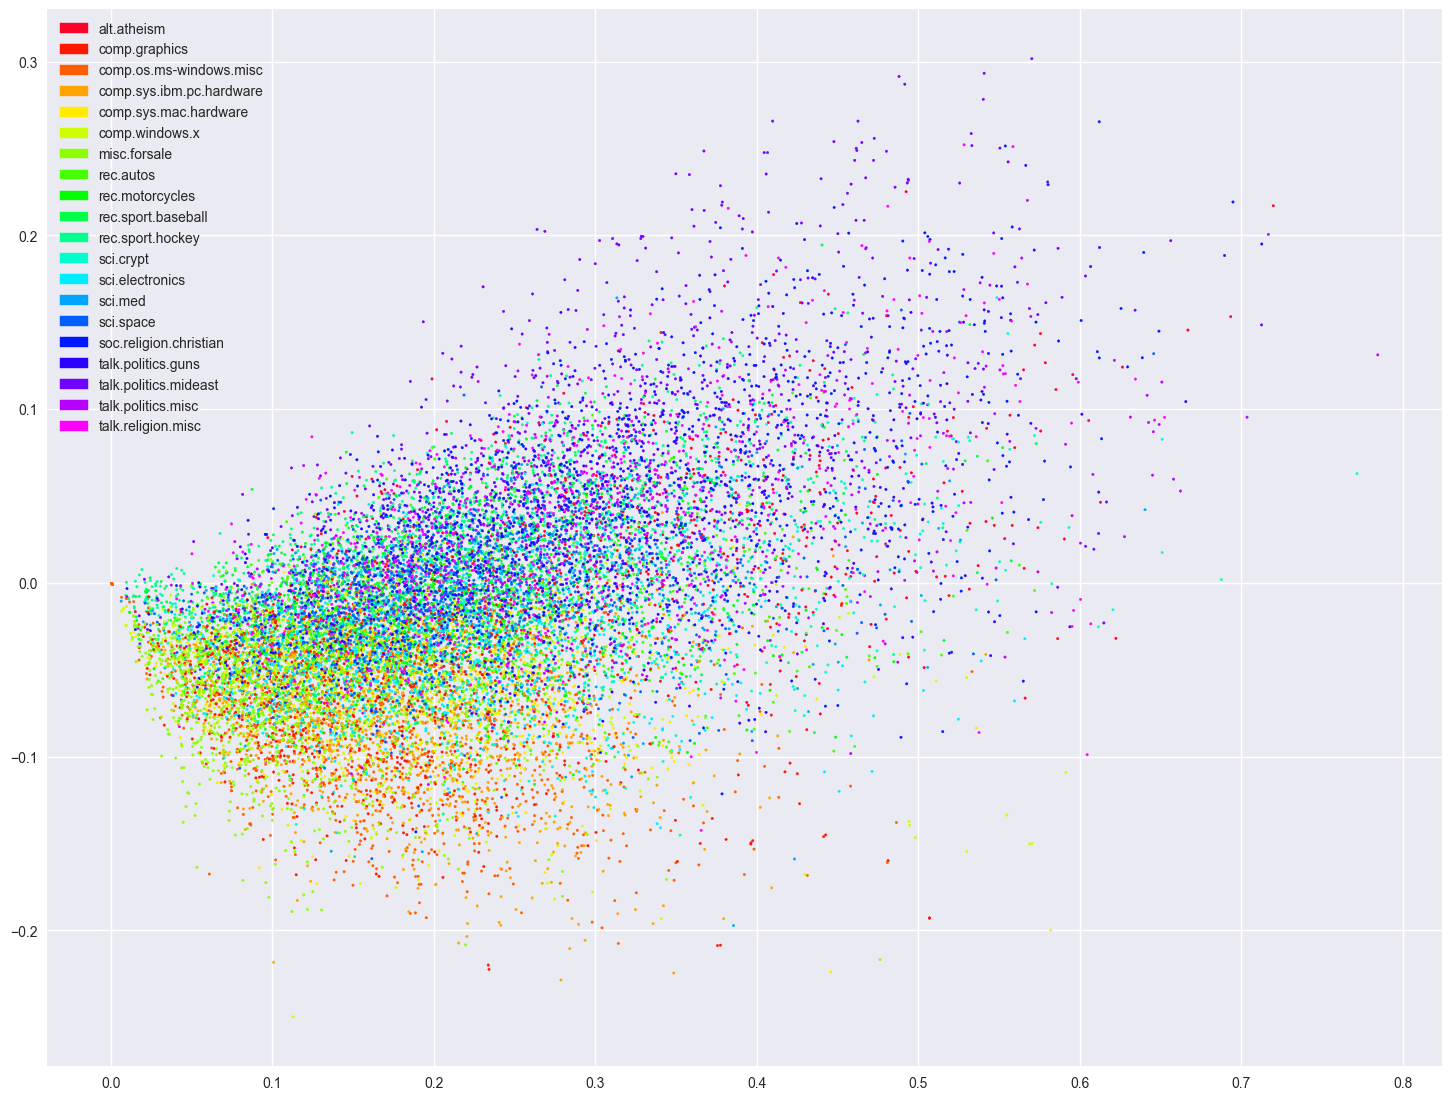

In [198]:
plt.figure(figsize(18, 14))
plt.scatter(X_svd_2[:, 0], X_svd_2[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Не зря. Зато выглядит симпатично.

# 2. TSNE

Казалось бы: ну все, теперь мы преодбработали данные, имеем вектора, размерность большая: закинем все в TSNE и получим красивую визуализацию, но нет.

Как было написано в начале, нелинейные методы не способны обработать экстремально большие размерности. t-SNE уменьшает размерность данных опираясь на локальные свойства, поэтому он не сработает на данных с очень большой размерностью.

Решение – использовать линейное уменьшение размерности и уже на нем прогонять все остальные алгоритмы.

In [130]:
# Для sparse данных идеально подойдет TruncatedSVD
X_svd = TruncatedSVD(100).fit_transform(X_trans)

Теперь мы готовы к уменьшению размерности

Рассмотрим некоторые параметры, которые есть у TSNE:

 -  ``n_components``: Результирующая размерность. TSNE устроен так, что результаты 
    будут плохо интерпретироваться при значениях больше 3 (а некоторые реализации и
    вовсе не поддерживают эти значения) Поэтому TSNE используется больше для визуализации.
    
По умолчанию – 2

 -  ``perplexity``: Количество соседних точек, будет определять качество 
    представления данных. Большие датасеты требуют большого значения, 
    Рекомендуется ставить значение от 5 до 50, но TSNE не чуствителен к этому параметру.
    
По умолчанию – 30

 -  ``metric``: Выбор метрики для подсчета расстояния между точками. Они есть [здесь](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

По умолчанию - euclidean

У нашей "быстрой" реализации TSNE есть параметр n_jobs, который сильно выручает, ставим его -1 (использовать все ядра).

P.S. Было решено даже не использовать обычную версию TSNE из sklearn, предполагается, что читателю известно, что выполнение не завершится за приемлемое время, так что я даже решил не ждать.

In [114]:
%%time
X_tsne = MulticoreTSNE(n_jobs=-1).fit_transform(X_svd)

CPU times: user 3min 21s, sys: 4.2 s, total: 3min 25s
Wall time: 3min 28s


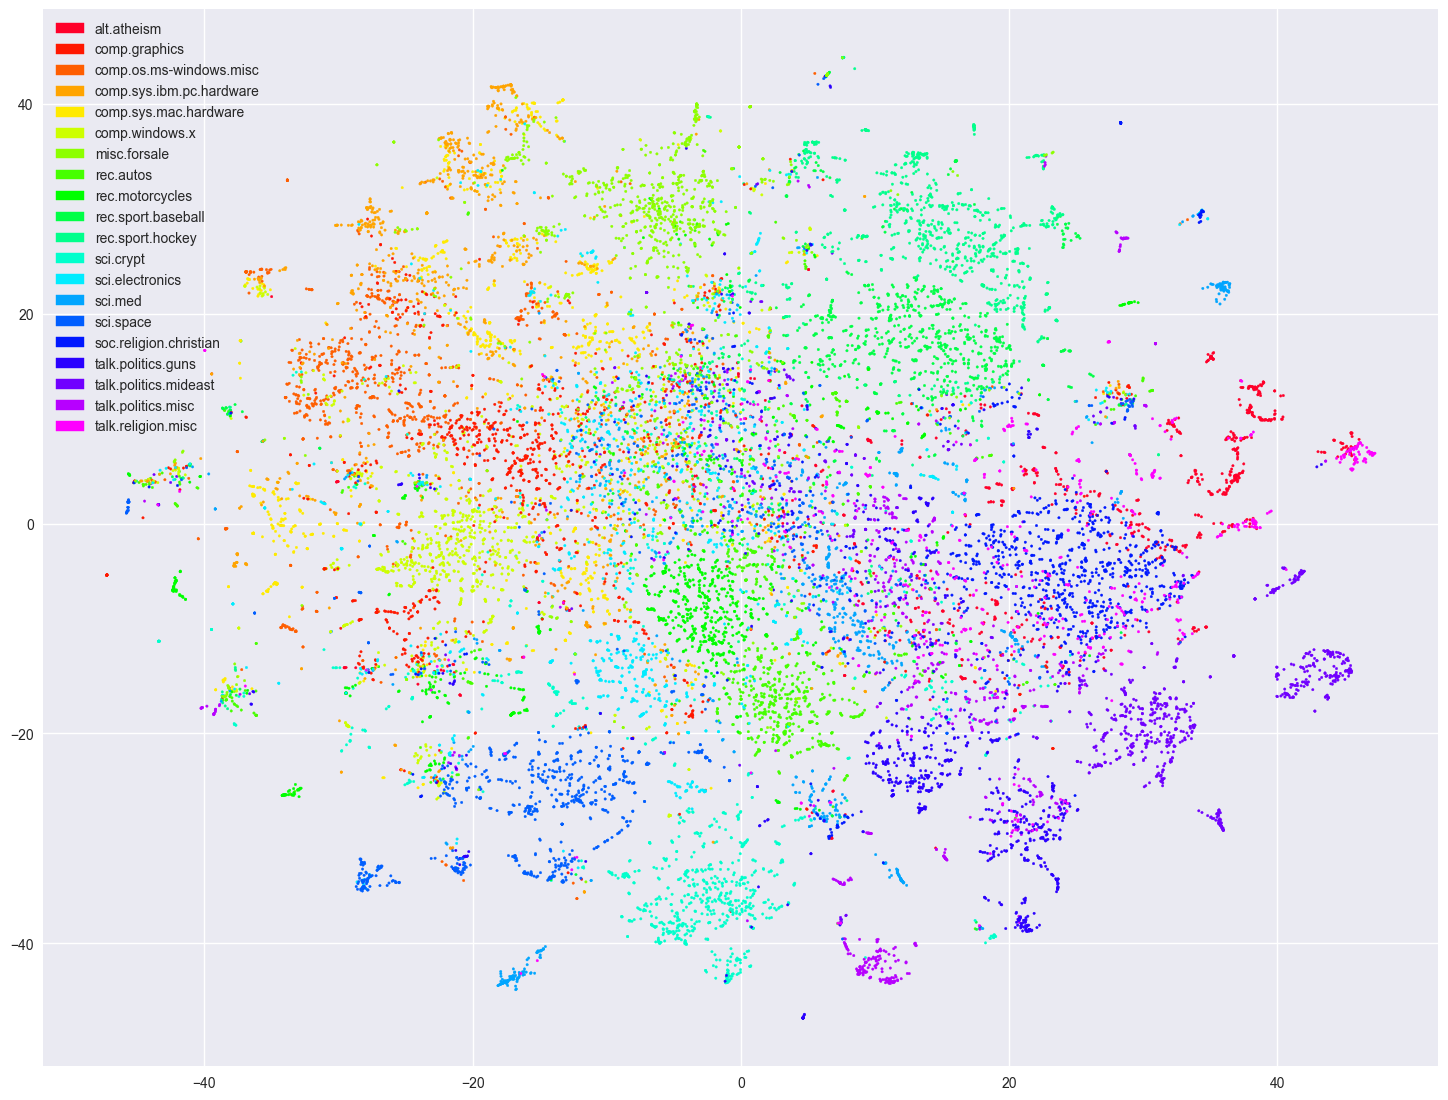

In [159]:
plt.figure(figsize(18, 14))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Видно, что евклидова метрика (по умолчанию) справляется плохо. Для векторов, получаемых из текста обычно используется косинусная мера.

In [107]:
%%time
X_tsne_cosine = MulticoreTSNE(metric='cosine', n_jobs=-1).fit_transform(X_svd)

CPU times: user 3min 21s, sys: 4.18 s, total: 3min 25s
Wall time: 3min 28s


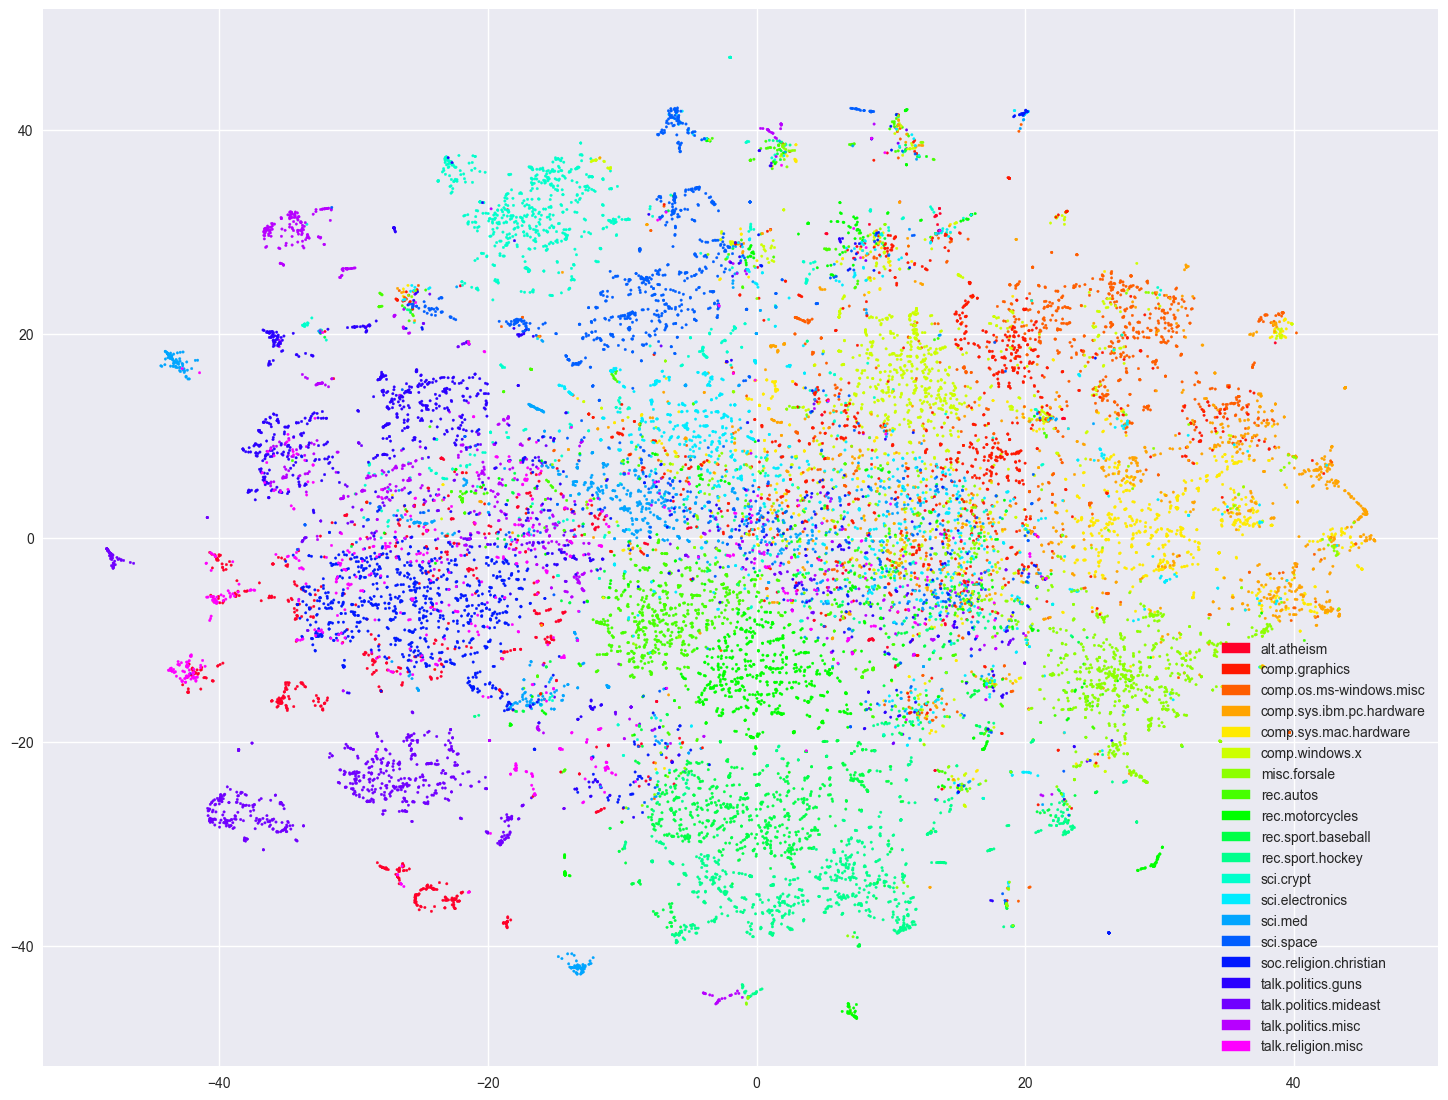

In [160]:
plt.figure(figsize(18, 14))
plt.scatter(X_tsne_cosine[:, 0], X_tsne_cosine[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Уже лучше, хоть в центре все равно не разобрать происходящее

Попробуем увеличить perplexity 

In [131]:
%%time
X_tsne_cosine_perplexity = MulticoreTSNE(perplexity=40, metric='cosine', n_jobs=-1).fit_transform(X_svd)

CPU times: user 3min 40s, sys: 3.45 s, total: 3min 44s
Wall time: 3min 47s


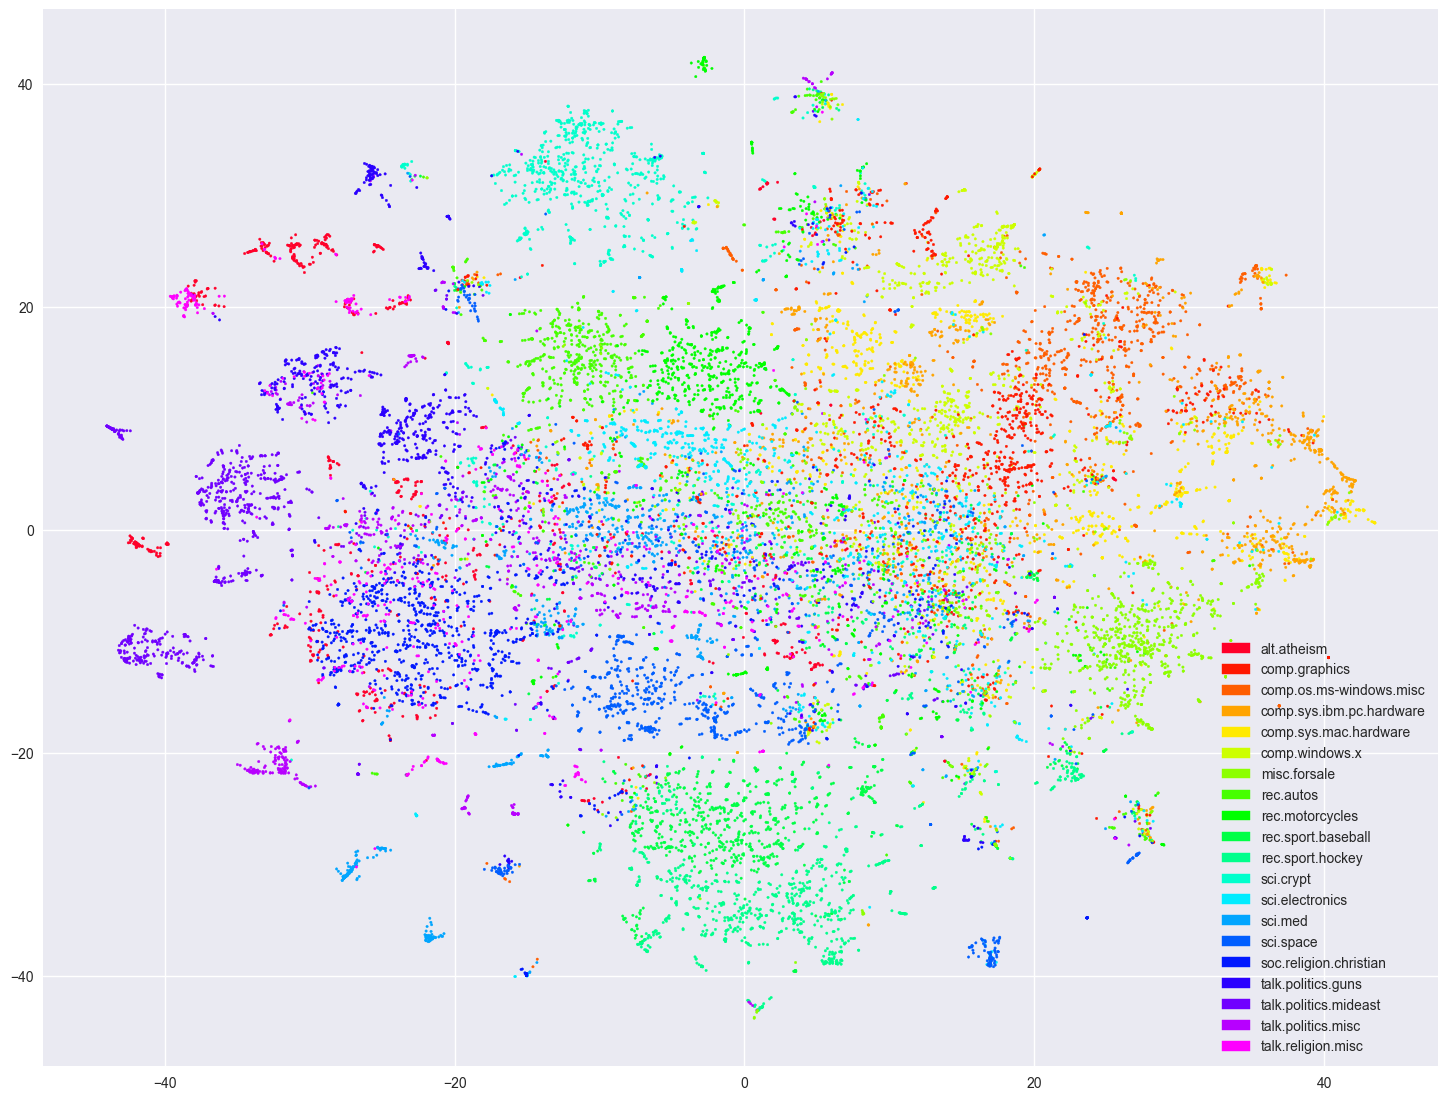

In [161]:
plt.figure(figsize(18, 14))
plt.scatter(X_tsne_cosine_perplexity[:, 0], X_tsne_cosine_perplexity[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Попробуем уменьшить perplexity

In [134]:
%%time
X_tsne_cosine_perplexity2 = MulticoreTSNE(perplexity=12, metric='cosine', n_jobs=-1).fit_transform(X_svd)

CPU times: user 8min 15s, sys: 1min 29s, total: 9min 45s
Wall time: 5min 8s


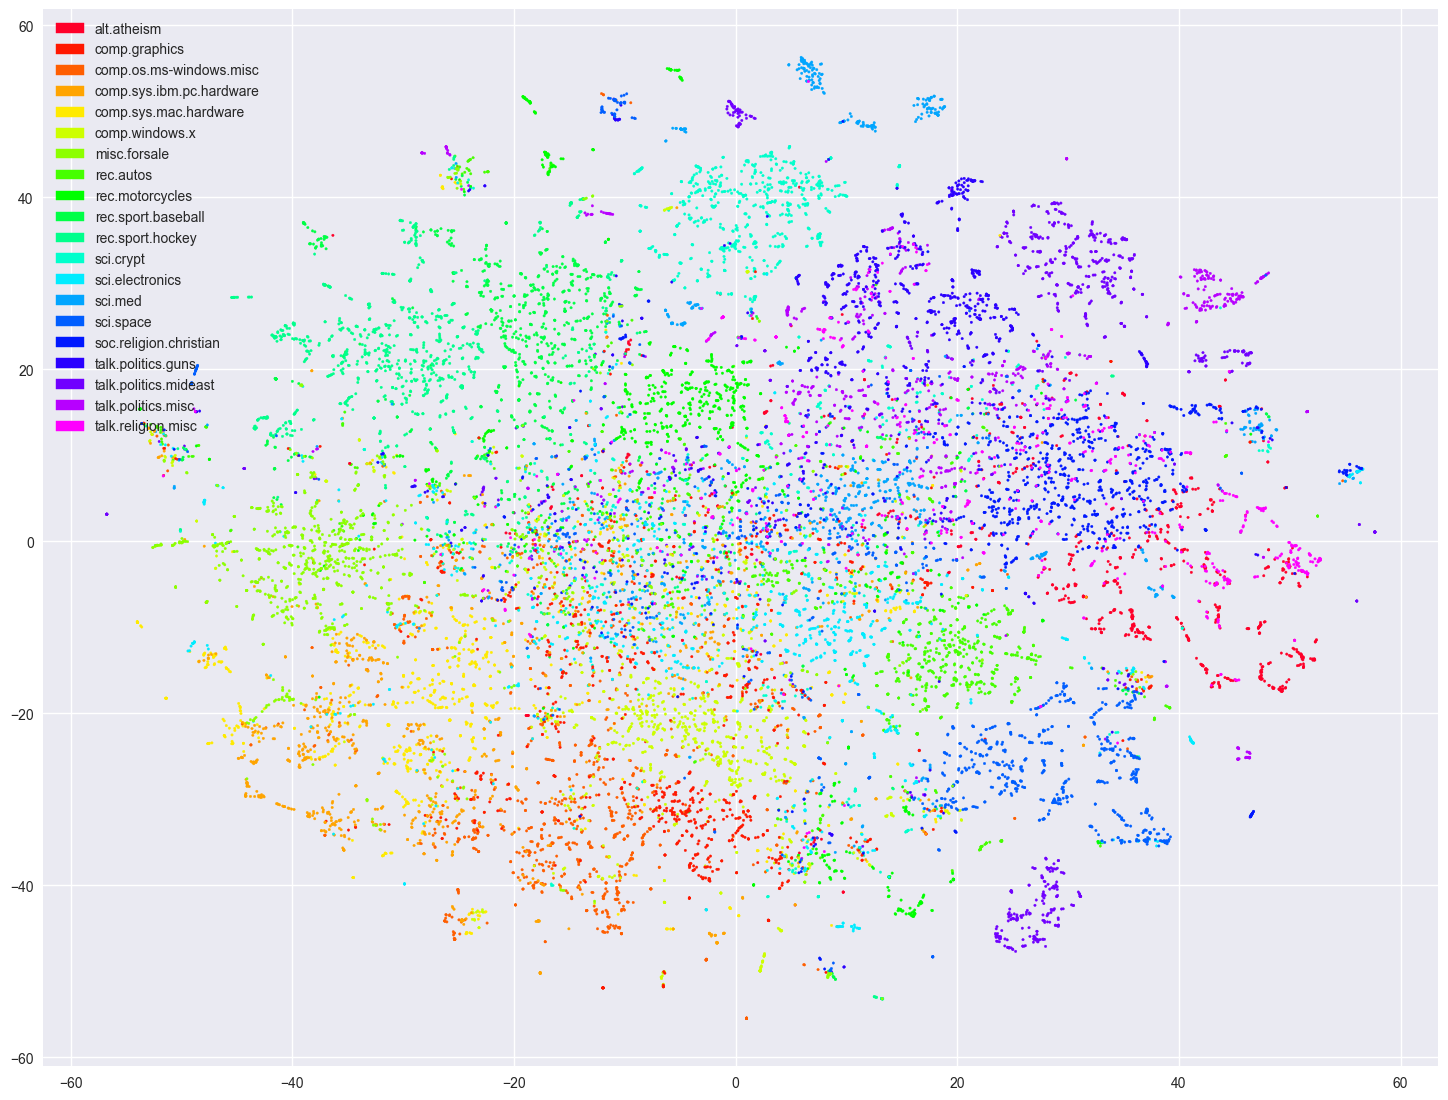

In [162]:
plt.figure(figsize(18, 14))
plt.scatter(X_tsne_cosine_perplexity2[:, 0], X_tsne_cosine_perplexity2[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Мы убедились, что параметр perplexity по большому счету ни на что не влияет и TSNE почти не конфигурируется

# 3. UMAP

Рассмотрим параметры, которые есть у uMAP:

 -  ``n_neighbors``: Количество соседних точек, будет определять качество 
    представления данных. Большое значение повлечет за собой более глобальную структуру, 
    потеряются особенности данных в небольшой окрестности. Рекомендуется ставить значение
    от 5 до 50, подстраивая под свои нужды. Стандартно от 10 до 15.

 -  ``min_dist``: Минимальная дистанция между точками в итоговом представлении.
    Большие значения более равномерно распределят точки, когда как маленькие
    восстановят зависимости в локальной окрестности. Рекомендуется изменять от
    0.001 до 0.5. Стандартно – 0.1.

 -  ``metric``: Выбор метрики для подсчета расстояния между точками. Можно задать свою
    функцию, предварительно оформив ее декоратором numba.jit

In [126]:
%%time
X_umap = UMAP(metric='cosine').fit_transform(X_svd)

CPU times: user 22.5 s, sys: 2.12 s, total: 24.6 s
Wall time: 23.3 s


Уже сейчас заметно ускорение в ~10 раз!

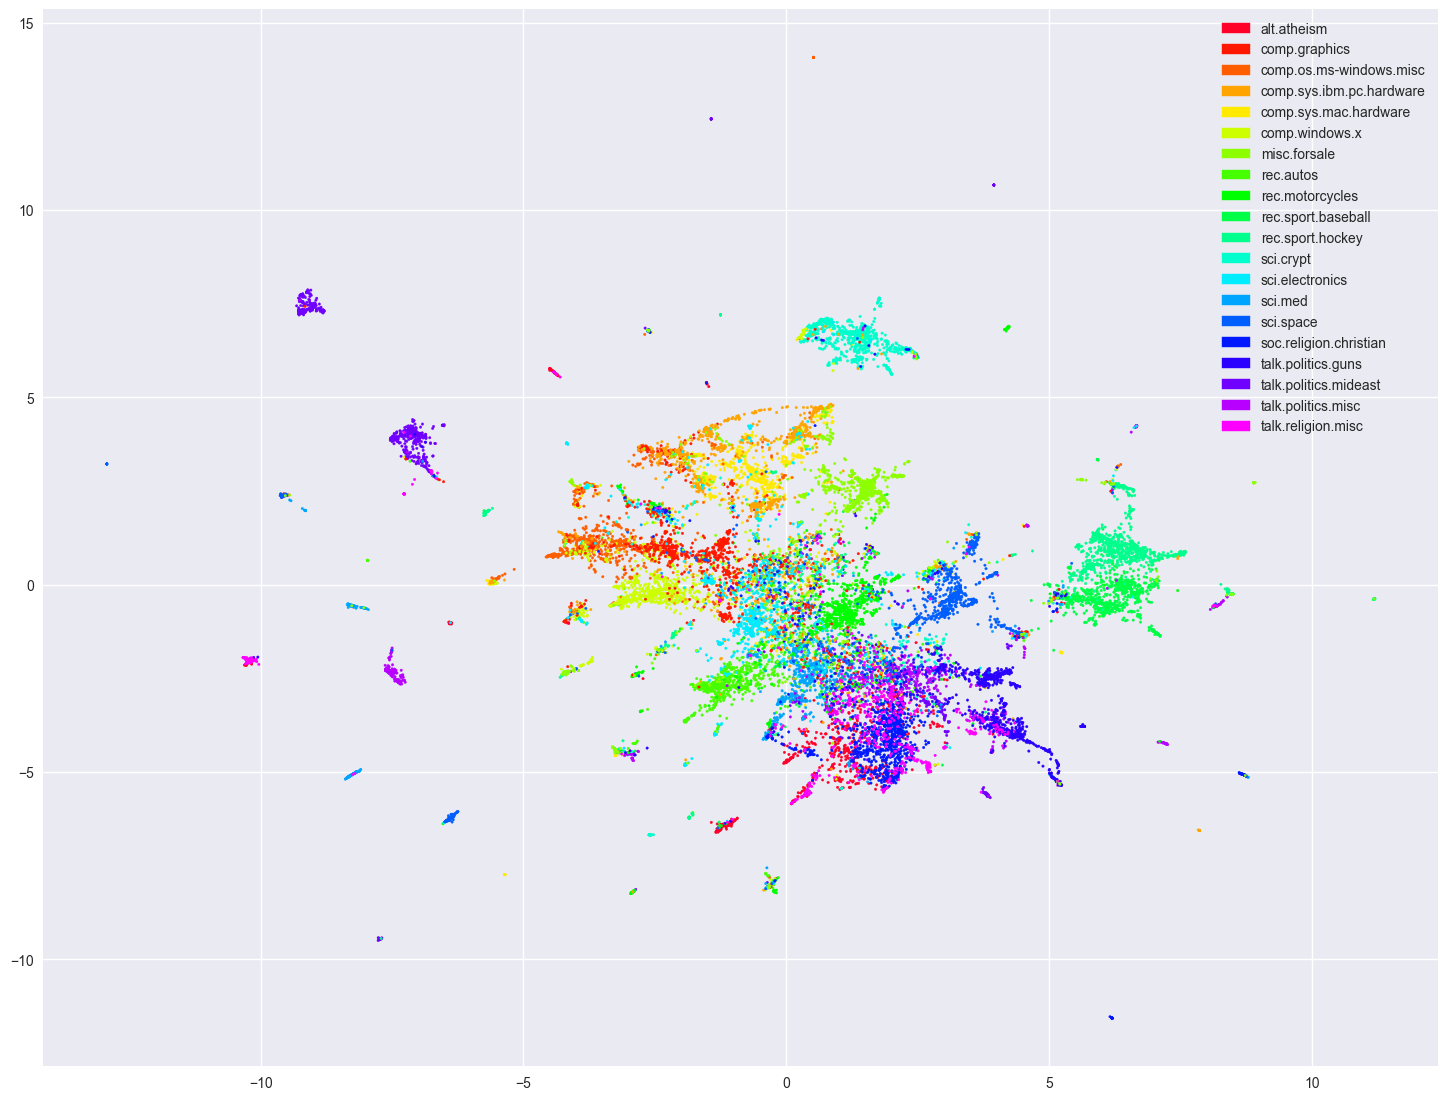

In [163]:
plt.figure(figsize(18, 14))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Выглядит тоже довольно симпатично, но вот какие-то отдаленные точки уж очень напоминают аутлаеры, а внутри наоборот все довольно плотно.
Поставим минимальную дистанцию в 2 раза больше и кол-во соседей поменьше

In [136]:
%%time
X_umap_tuned = UMAP(n_neighbors=8, min_dist=0.2, metric='cosine').fit_transform(X_svd)

CPU times: user 17.2 s, sys: 1.79 s, total: 19 s
Wall time: 17.2 s


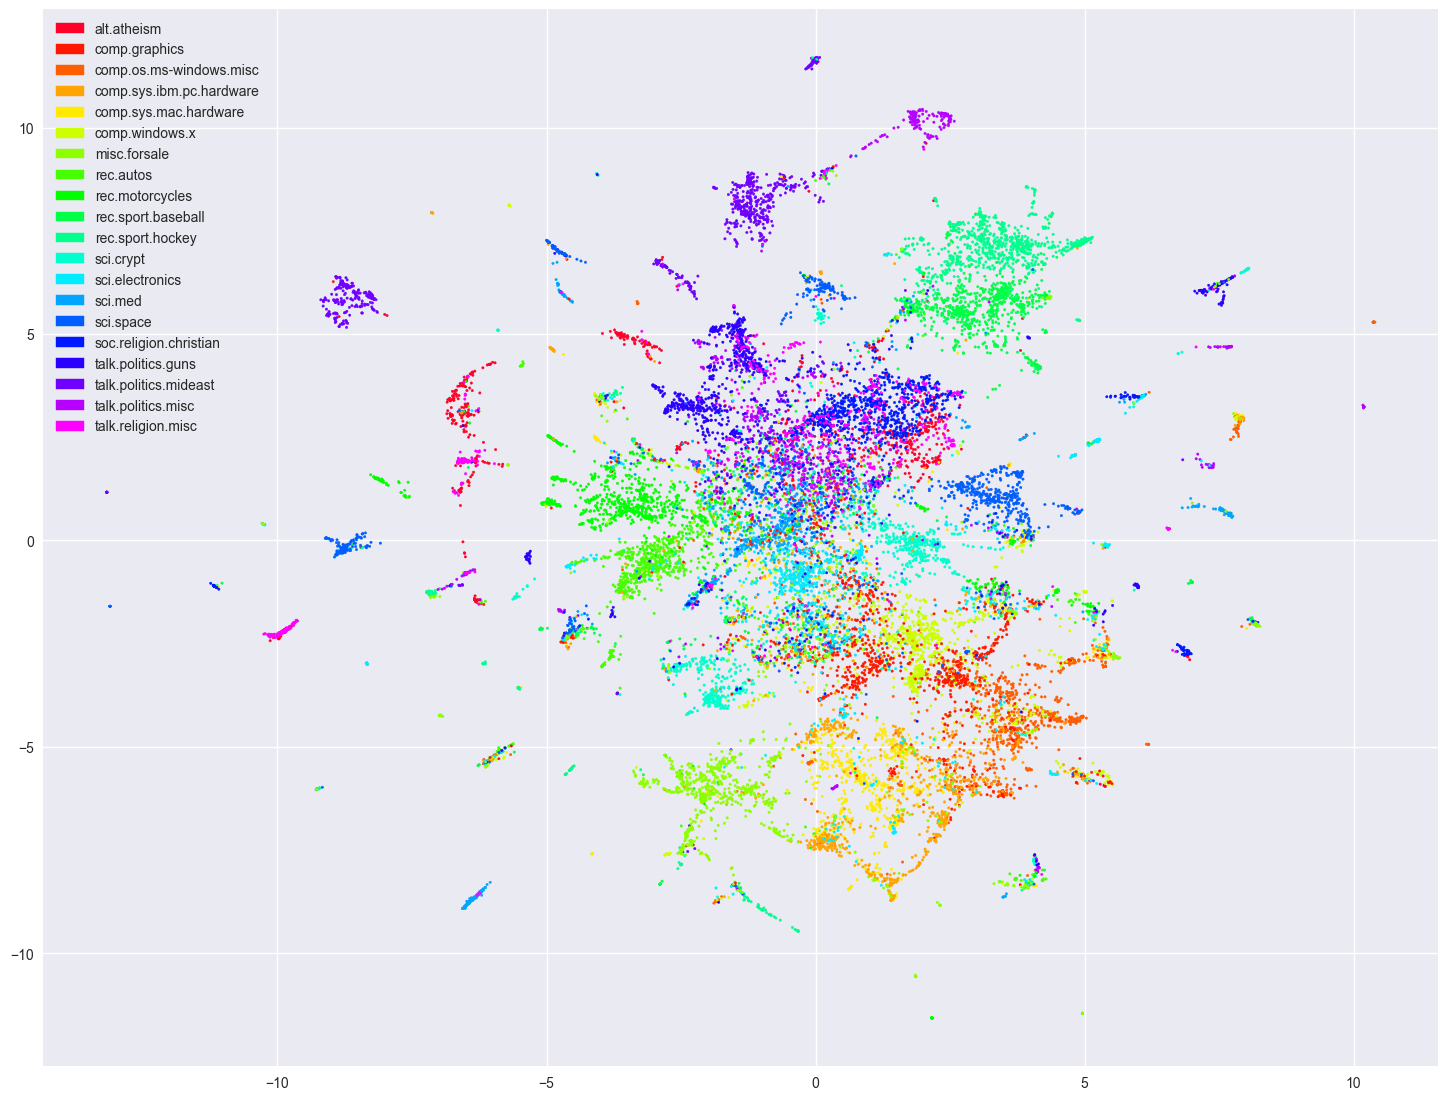

In [157]:
plt.figure(figsize(18, 14))
plt.scatter(X_umap_tuned[:, 0], X_umap_tuned[:, 1], s=3, c=[colors[l] for l in y])
plt.legend(handles=patches)

Вот такое представление данных мне нравится больше! Но что если данные в центре просто не способны отобразиться на плоскость? 

Отобразим на 3-мерное пространство

In [138]:
%%time
X_umap_tuned_3d = UMAP(n_components=3, n_neighbors=8, min_dist=0.2, metric='cosine').fit_transform(X_svd)

CPU times: user 17.8 s, sys: 1.83 s, total: 19.7 s
Wall time: 18 s


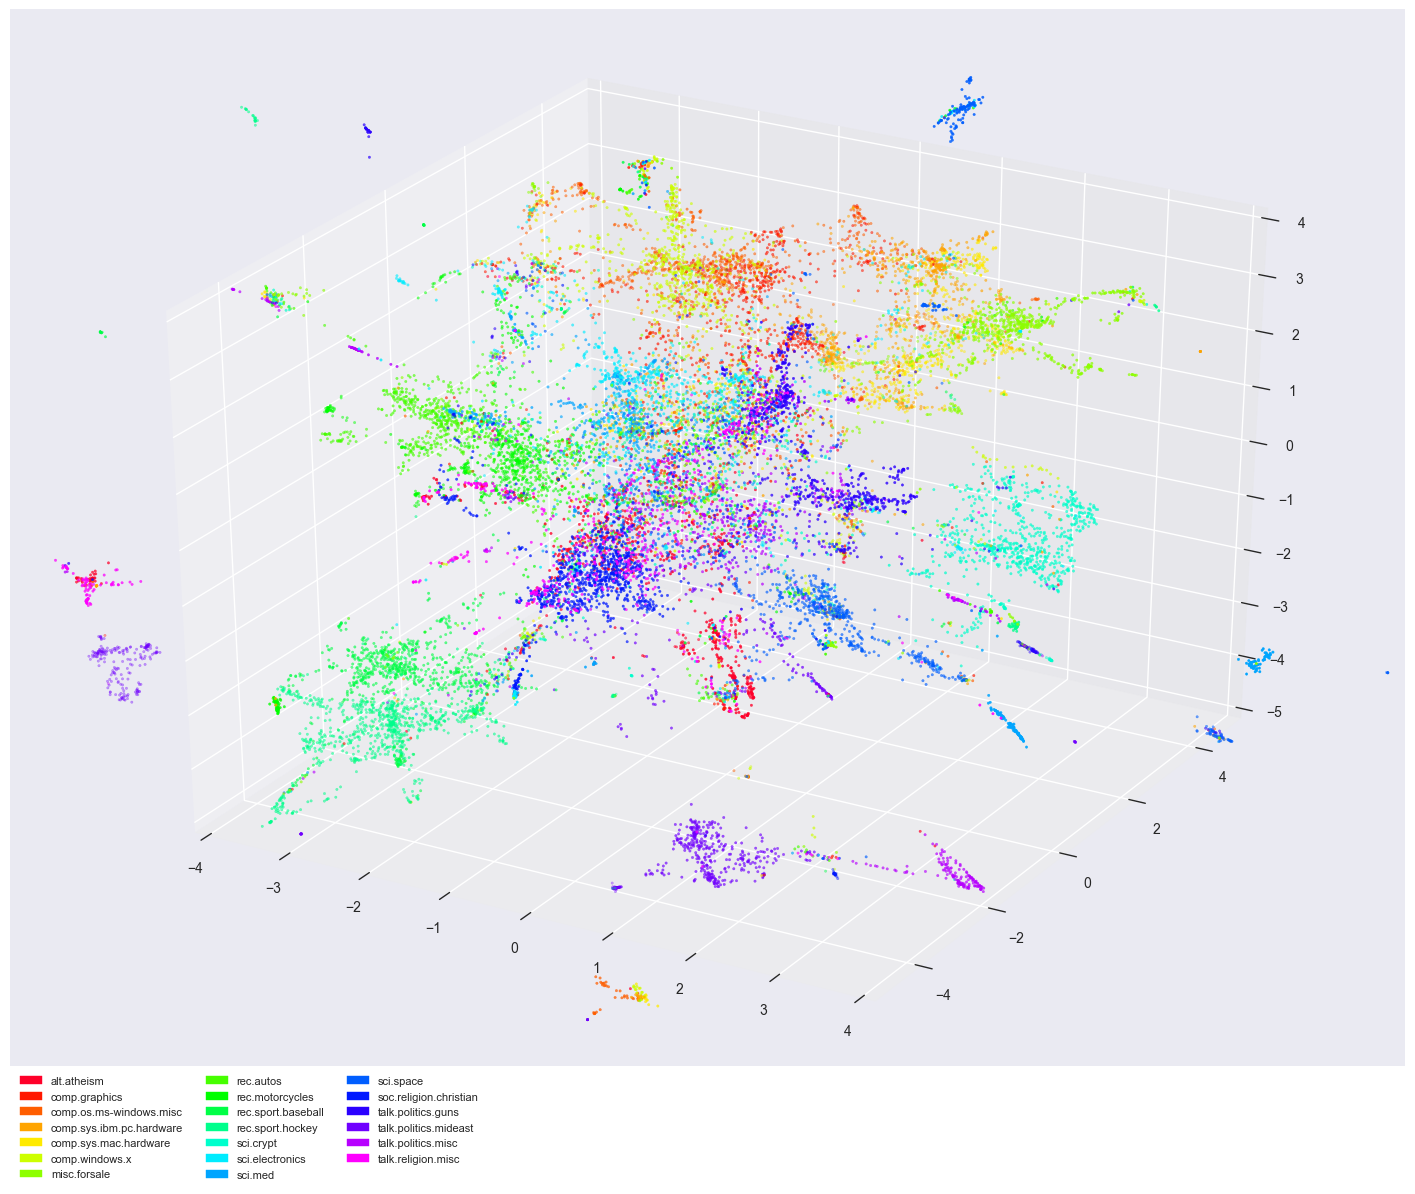

<Figure size 1800x1400 with 0 Axes>

In [193]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')
plt.figure(figsize(18, 14))
ax.scatter(X_umap_tuned_3d[:, 0], X_umap_tuned_3d[:, 1], X_umap_tuned_3d[:, 2], s=3, c=[colors[l] for l in y])
ax.set_zlim3d(-5, 4)
ax.set_ylim3d(-5, 5)
ax.set_xlim3d(-4, 4)
ax.legend(handles=patches, loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

Теперь, когда мы построили неплохое распределение мы можем обучить логистическую регрессию на исходных (не уменьшенных) векторах и попытаться сопоставить те, которые были плохо выделены в кластер с их итоговым скором.

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, LabelEncoder().fit_transform(y))
y_predicted = LogisticRegression().fit(X_train, y_train).predict(X_test)

In [196]:
print(classification_report(y_test, y_predicted, target_names=unique_y))

                          precision    recall  f1-score   support

             alt.atheism       0.89      0.90      0.89       207
           comp.graphics       0.76      0.88      0.81       226
 comp.os.ms-windows.misc       0.87      0.84      0.86       261
comp.sys.ibm.pc.hardware       0.82      0.83      0.82       253
   comp.sys.mac.hardware       0.92      0.86      0.89       244
          comp.windows.x       0.84      0.90      0.87       246
            misc.forsale       0.77      0.87      0.81       247
               rec.autos       0.94      0.91      0.93       233
         rec.motorcycles       0.96      0.95      0.96       253
      rec.sport.baseball       0.97      0.96      0.96       255
        rec.sport.hockey       0.98      0.97      0.97       220
               sci.crypt       0.98      0.90      0.94       269
         sci.electronics       0.81      0.86      0.83       222
                 sci.med       0.94      0.93      0.93       252
         

Все точки из категории 'rec' (зеленого цвета) хорошо выделены в кластеры, это подтверждается большим скором в таблице

'talk.religion.misc' определяется плохо, оно и понятно, ведь это категория "прочее"

# 4. Выводы

Мы еще раз за время курса попробовали уменьшить размерность данных и визуализировать данные, познакомились с библиотекой UMAP, которая (на мой взгляд) строит более совершенные визуализации с возможностью настройки, да еще и намного быстрее.